<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/production_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Production Analysis

## Uploading packages and data

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Remove previous versions of the uploaded excel file
!rm production_j4_2021.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded = files.upload()

Saving production_j4_2021.xlsx to production_j4_2021.xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df = pd.read_excel(io.BytesIO(uploaded['production_j4_2021.xlsx']), index_col='Event') #==> setting Event (datetime) as index to perform date slicing

In [ ]:
#Checking the dataframe information
df.info()

In [ ]:
#Checking the dataframe index
df.index[0], df.index[-1]

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-05-09 23:00:00'))

## Filtering data for daily meeting

In [ ]:
#Filtering the dataframe to match the last 24 hours
s = '2021-05-27 08:00:00'
f = '2021-05-28 07:00:00'
last_24 = df[s : f].copy()
last_24.index[0], last_24.index[-1]

(Timestamp('2021-05-05 08:00:00'), Timestamp('2021-05-07 07:00:00'))

In [ ]:
#Grouping and aggregating the data to estimate different parameters for each shift and day

def util(x):
  '''Custom function to calculate the utilization of each machine'''
  return (x.sum()/x.count())*100

groupped = last_24.groupby(['Weeknum', 'S_num', 'Shift', 'Mass', 'Group', 'Product', 'Format']).agg({'Form_min': 'mean',
                                                                                                    'Hours': 'count',
                                                                                                    'Boxes': 'sum',
                                                                                                    'GE': 'mean',
                                                                                                    'GE_loss': 'mean',
                                                                                                    'Min_loss': 'sum',
                                                                                                    'A1764': util,
                                                                                                    'PK2219': util,
                                                                                                    'PK2845': util,
                                                                                                    'PK4553': util,
                                                                                                    'Schubert': util,
                                                                                                    'K6316': util,
                                                                                                    'TP6839': util
                                                                                                    }).reset_index()

In [ ]:
#Exporting to excel into local disk
from google.colab import files
groupped.to_excel('z_grouped_24.xlsx', index=False) #==> Excluding index from file
files.download('z_grouped_24.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Grouping data by Waterfall codes

In [ ]:
#Filtering the dataframe to match the last week
s = '2021-04-26 07:00:00'
f = '2021-04-30 22:00:00'
week = df[s : f].copy()
week.index[0], week.index[-1]

(Timestamp('2021-04-26 07:00:00'), Timestamp('2021-04-30 22:00:00'))

In [ ]:
#Grouping and aggregating the data by waterfall coding according to previous date slicing

wf = week.groupby(['Weeknum', 'State', 'T_loss']).agg({'Hours': 'count', 'GE': 'mean', 'GE_loss': 'mean', 'Min_loss': 'sum'}).reset_index()

In [ ]:
#Exporting to excel in local disk
from google.colab import files
wf.to_excel('wf_grouped_j4.xlsx', index=False) #==> Excluding index from file
files.download('wf_grouped_j4.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Dropping Shutdown and Grouping by State

In [ ]:
#Filtering the dataframe to exclude Shutdown Time
st = df[~df['T_loss'].isin(['Shutdown'])].copy()
st.tail(2)

,Date,Hours,Weeknum,Weekday,Shift,S_num,State,T_loss,Mass,Group,Product,Format,Team,XO_num,XO_type,FTE_loss,Form_min,A1764,PK2219,PK2845,PK4553,Schubert,K6316,TP6839,Boxes,GE,GE_loss,Min_loss,Machine,Workpoint,Comment
Event,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-28 22:00:00,2021-03-28,22:00:00,13,Sunday,Afternoon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-28 23:00:00,2021-03-28,23:00:00,13,Sunday,Night,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Filtering the dataframe to match planned production time
s = '2021-01-04 07:00:00'
f = '2021-03-23 07:00:00'
ppt = st[s : f].copy()
ppt.index[0], ppt.index[-1]

(Timestamp('2021-01-04 07:00:00'), Timestamp('2021-03-23 07:00:00'))

In [ ]:
#Grouping and aggregating the data by waterfall coding according to previous date slicing

st = ppt.value_counts(subset=['State', 'T_loss'], normalize=True).reset_index(name='Proportion') #==> Rename column series after resetting the index
st

,State,T_loss,Proportion
0,22_Operating,Operating,0.480430
1,9_Changeover,Planned,0.120491
2,8_Sanitation,Planned,0.112049
3,18_Op_Losses,Unplanned,0.099770
4,17_Breakdown,Unplanned,0.079048
5,20_Speed_Loss,Unplanned,0.029163
6,12_Start_Finish,Planned,0.024559
7,10_Planned_Stop,Planned,0.021489
8,19_Line_Delays,Unplanned,0.014582
9,14_Labor_Losses,Unplanned,0.013814


In [ ]:
#Exporting to excel in local disk
from google.colab import files
st.to_excel('wf_state_j4.xlsx', index=False) #==> Excluding index from file
files.download('wf_state_j4.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Greens vs Reds analysis

In [ ]:
#Uploading file from local drive ==> !rm file
from google.colab import files
uploaded = files.upload()

Saving 2021_j4_grouped.xlsx to 2021_j4_grouped (3).xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df = pd.read_excel(io.BytesIO(uploaded['2021_j4_grouped.xlsx']), index_col='Date') #==> Set date column as index

In [ ]:
#Checking the dataframe head
df.head()

,Variant,Weeknum,S_num,Shift,Mass,Group,Product,Format,Form_min,Hours,Boxes,GE,GE_loss,Min_loss,A1764,PK2219,PK2845,PK4553,Schubert,K6316,TP6839,Kr_loss,Comment
Date,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,1,1,1,Day,Norsk,Løsvekt,Melkerull_10kg,10kg,14.666667,6,114,31.666667,68.333333,246.000000,50.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,15575.900000,NaN
2021-01-04,2,1,1,Day,Svensk,Massive,Milkroll,2pk,28.333333,3,48,8.988764,91.011236,163.820225,100.0,0.0,66.666667,66.666667,66.666667,0.0,66.666667,10372.550562,NaN
2021-01-04,3,1,2,Afternoon,Svensk,Massive,Milkroll,2pk,27.857143,7,1003,80.497592,19.502408,81.910112,100.0,100.0,100.000000,0.000000,100.000000,0.0,100.000000,5186.275281,NaN
2021-01-04,4,1,3,Night,Svensk,Massive,Milkroll,2pk,23.000000,1,89,89.000000,11.000000,6.600000,100.0,100.0,100.000000,0.000000,100.000000,0.0,100.000000,417.890000,NaN
2021-01-04,5,1,3,Night,Svensk,Massive,Mjölkchoklad,single,23.875000,8,2440,89.387755,10.612245,50.938776,100.0,87.5,87.500000,0.000000,87.500000,50.0,0.000000,3225.273469,NaN


In [ ]:
#Checking the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2021-01-04 to 2021-04-06
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variant   232 non-null    int64  
 1   Weeknum   232 non-null    int64  
 2   S_num     232 non-null    int64  
 3   Shift     232 non-null    object 
 4   Mass      221 non-null    object 
 5   Group     221 non-null    object 
 6   Product   221 non-null    object 
 7   Format    221 non-null    object 
 8   Form_min  232 non-null    float64
 9   Hours     232 non-null    int64  
 10  Boxes     232 non-null    int64  
 11  GE        232 non-null    float64
 12  GE_loss   232 non-null    float64
 13  Min_loss  232 non-null    float64
 14  A1764     232 non-null    float64
 15  PK2219    232 non-null    float64
 16  PK2845    232 non-null    float64
 17  PK4553    232 non-null    float64
 18  Schubert  232 non-null    float64
 19  K6316     232 non-null    float64
 20  TP6839    232

In [ ]:
#Dropping missing values
df = df[~df['Mass'].isin([np.nan])]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 221 entries, 2021-01-04 to 2021-04-06
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variant   221 non-null    int64  
 1   Weeknum   221 non-null    int64  
 2   S_num     221 non-null    int64  
 3   Shift     221 non-null    object 
 4   Mass      221 non-null    object 
 5   Group     221 non-null    object 
 6   Product   221 non-null    object 
 7   Format    221 non-null    object 
 8   Form_min  221 non-null    float64
 9   Hours     221 non-null    int64  
 10  Boxes     221 non-null    int64  
 11  GE        221 non-null    float64
 12  GE_loss   221 non-null    float64
 13  Min_loss  221 non-null    float64
 14  A1764     221 non-null    float64
 15  PK2219    221 non-null    float64
 16  PK2845    221 non-null    float64
 17  PK4553    221 non-null    float64
 18  Schubert  221 non-null    float64
 19  K6316     221 non-null    float64
 20  TP6839    221

In [ ]:
#Filtering the dataframe to match planned production time
s = '2021-02-01'
f = '2021-04-06'
ft_df = df[s : f].copy()
ft_df.index[0], ft_df.index[-1]

(Timestamp('2021-02-01 00:00:00'), Timestamp('2021-04-06 00:00:00'))

In [ ]:
#Assign categorical columns of greens and reds
ft_df = ft_df.assign(Cat = lambda x: np.where((x['Product']=='Melkerull') |
                                              (x['Product']=='Krokanrull') |
                                              (x['Product']=='Smil'),
                                              "Green", "Red"))
ft_df.head()

,Variant,Weeknum,S_num,Shift,Mass,Group,Product,Format,Form_min,Hours,Boxes,GE,GE_loss,Min_loss,A1764,PK2219,PK2845,PK4553,Schubert,K6316,TP6839,Kr_loss,Comment,Cat
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-01,84,5,61,Day,Norsk,Fylte,Mintchoko,single,0.000000,1,0,0.000000,100.000000,60.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3799.000000,NaN,Red
2021-02-01,85,5,61,Day,Svensk,Massive,Mjölkchoklad,single,18.500000,8,640,18.018018,81.981982,393.513514,62.5,0.0,25.0,25.0,25.0,25.0,0.0,24915.963964,NaN,Red
2021-02-01,86,5,62,Afternoon,Svensk,Massive,Mjölkchoklad,single,27.000000,7,2979,95.849421,4.150579,36.351351,100.0,0.0,100.0,100.0,100.0,100.0,0.0,2301.646396,NaN,Red
2021-02-01,87,5,63,Night,Svensk,Massive,Mjölkchoklad,single,27.466667,9,3708,97.823129,2.176871,11.755102,100.0,0.0,100.0,100.0,100.0,100.0,0.0,744.293878,NaN,Red
2021-02-02,88,5,64,Day,Svensk,Massive,Mjölkchoklad,single,25.750000,8,1974,55.574324,44.425676,213.648649,100.0,0.0,75.0,100.0,100.0,100.0,0.0,13527.520270,NaN,Red


In [ ]:
#Counting values of Greens and Reds
ft_df['Cat'].value_counts()

Red      83
Green    55
Name: Cat, dtype: int64

In [ ]:
#Initializing 2 lists
a = [8, 7, 9]
b = [61.8, 79.5, 96.2]

In [ ]:
#Example of weighted average using numpy
np.dot(a, b)/np.sum(a)

79.8625

In [ ]:
#Define a custom function to get the weighted average for several columns
def weighted(x):
  d = {}
  d['Hours'] = np.sum(x['Hours'])
  d['Molds_min'] = np.dot(x['Hours'], x['Form_min'])/np.sum(x['Hours'])
  d['GE'] = np.dot(x['Hours'], x['GE'])/np.sum(x['Hours'])
  d['GE_loss'] = np.dot(x['Hours'], x['GE_loss'])/np.sum(x['Hours'])
  d['Min_loss'] = np.sum(x['Min_loss'])
  return pd.Series(d, index=['Hours', 'Molds_min', 'GE', 'GE_loss', 'Min_loss'])

In [ ]:
#Aggreated information for greens and reds
green_red = ft_df.groupby(['Cat']).apply(weighted).reset_index()
green_red = round(green_red, 2)
green_red

,Cat,Hours,Molds_min,GE,GE_loss,Min_loss
0,Green,379.0,19.40,72.32,27.68,6330.67
1,Red,445.0,19.18,65.25,34.75,9368.74


In [ ]:
#Aggreated information for greens and reds
green_red = ft_df.groupby(['Cat']).agg(Hours=('Hours', 'sum'),
                                       Molds_min=('Form_min','mean'),
                                       GE=('GE','mean'),
                                       GE_loss=('GE_loss','mean'),
                                       Min_loss=('Min_loss','sum')).reset_index()
green_red = round(green_red, 2)
green_red

,Cat,Hours,Molds_min,GE,GE_loss,Min_loss
0,Green,379,18.43,69.59,30.41,6330.67
1,Red,445,19.42,63.25,36.75,9368.74


In [ ]:
#Grouping the data by product categories and aggregating to compute weighted average
prod_groupped = ft_df.groupby(['Cat', 'Group', 'Product', 'Format']).apply(weighted).reset_index()
prod_groupped = round(prod_groupped, 2)
prod_groupped

,Cat,Group,Product,Format,Hours,Molds_min,GE,GE_loss,Min_loss
0,Green,Fylte,Smil,2pk,22.0,6.95,52.49,47.51,627.11
1,Green,Fylte,Smil,single,124.0,13.82,66.16,33.84,2518.97
2,Green,Ingredienser,Krokanrull,single,49.0,22.24,69.09,30.91,923.46
3,Green,Massive,Melkerull,single,184.0,23.88,79.70,20.30,2261.13
4,Red,Fylte,Mintchoko,single,58.0,10.12,51.84,48.16,1675.85
5,Red,Ingredienser,Daim_roll,2pk,104.0,19.79,68.91,31.09,1945.11
6,Red,Ingredienser,Daim_roll,single,36.0,23.03,60.32,39.68,871.64
7,Red,Ingredienser,Oreo,single,8.0,20.39,70.61,29.39,141.06
8,Red,Ingredienser,Schweitsernøtt,single,15.0,22.12,71.81,28.19,258.56
9,Red,Løsvekt,Melkerull_10kg,10kg,3.0,20.20,55.00,45.00,81.00


In [ ]:
#Define a custom function to compute the weighted average between 2 arrays
def w_average(array1, array2):
  """Function used to compute the weighted average between two arrays
    array1 is the dividend and array2 is the divisor"""
  return (np.dot(array1, array2)/np.sum(array2))

In [ ]:
#Select streams to check weighted average
greens = np.array(prod_groupped[prod_groupped['Cat']=='Green']['GE'])
greens_hr = np.array(prod_groupped[prod_groupped['Cat']=='Green']['Hours'])

In [ ]:
w_average(greens, greens_hr)

72.31881266490765

#Create time series template

In [ ]:
#Creating a dataframe with time series for each hour, and computing categorical values for year, week number and weekday
ts = pd.DataFrame()
ts = ts.assign(Event = pd.date_range(start='2021-04-20', end='2021-05-10', freq='1H', name='Event'))
ts = ts.assign(#Year = ts['Event'].dt.isocalendar().year,
#               Month = ts['Event'].dt.month_name(),
#               Weeknum = ts['Event'].dt.isocalendar().week,
               Weekday = ts['Event'].dt.day_name())

In [ ]:
ts.tail()

,Event,Weekday
476,2021-05-09 20:00:00,Sunday
477,2021-05-09 21:00:00,Sunday
478,2021-05-09 22:00:00,Sunday
479,2021-05-09 23:00:00,Sunday
480,2021-05-10 00:00:00,Monday


In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Event    17521 non-null  datetime64[ns]
 1   Year     17521 non-null  UInt32        
 2   Month    17521 non-null  object        
 3   Weeknum  17521 non-null  UInt32        
 4   Weeday   17521 non-null  object        
dtypes: UInt32(2), datetime64[ns](1), object(2)
memory usage: 581.9+ KB


In [ ]:
from google.colab import files
ts.to_excel('production_template.xlsx', index=False) #==> Excluding index from file
files.download('production_template.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Changeovers

##Data slicing and preparation

In [ ]:
#Filtering the dataframe to exclude Non operating time and no shift
df3 = df.copy()
df3 = df3[~df3['State'].isin(['2_Legal_NOT', '3_No_Shift'])]
df3 = df3.drop(columns = ['FTE_loss', 'Form_min', 'A1764', 'PK2219', 'PK2845','PK4553', 'Schubert', 'K6316', 'TP6839'], axis = 1)
df3.head(2)

,Date,Hours,Weeknum,Weekday,Shift,S_num,State,T_loss,Mass,Group,Product,Format,Team,XO_num,XO_cat,XO_type,Boxes,GE,GE_loss,Min_loss,Comment
Event,,,,,,,,,,,,,,,,,,,,,
2021-01-04 07:00:00,2021-01-04,07:00:00,1,Monday,Day,1.0,18_Op_Losses,Unplanned,Norsk,Løsvekt,Melkerull_10kg,10kg,Mfen,NaN,NaN,NaN,0.0,0.0,100.0,60.0,Crash in knockers area
2021-01-04 08:00:00,2021-01-04,08:00:00,1,Monday,Day,1.0,18_Op_Losses,Unplanned,Norsk,Løsvekt,Melkerull_10kg,10kg,Mfen,NaN,NaN,NaN,0.0,0.0,100.0,60.0,Crash in knockers area


In [ ]:
#Filtering the dataframe to select only changeover activities
df_xo = df3[df3['State'].isin(['9_Changeover'])].copy()
df_xo.tail(2)

,Date,Hours,Weeknum,Weekday,Shift,S_num,State,T_loss,Mass,Group,Product,Format,Team,XO_num,XO_cat,XO_type,Boxes,GE,GE_loss,Min_loss,Comment
Event,,,,,,,,,,,,,,,,,,,,,
2021-05-06 12:00:00,2021-05-06,12:00:00,18,Thursday,Day,234.0,9_Changeover,Planned,Norsk,Fylte,Smil,single,Tles,92.0,parallell,sing_sing,0.0,0.0,100.0,60.0,NaN
2021-05-06 15:00:00,2021-05-06,15:00:00,18,Thursday,Day,234.0,9_Changeover,Planned,Norsk,Fylte,Mintchoko,single,Tles,92.0,parallell,sing_sing,0.0,0.0,100.0,60.0,NaN


In [ ]:
#Filtering the dataframe to match the desired time slice
s = '2021-05-04 08:00:00'
f = '2021-05-07 07:00:00'
c_over = df_xo[s : f].copy()
c_over.reset_index(inplace = True)
c_over['Event'].iloc[-1]

Timestamp('2021-05-06 15:00:00')

In [ ]:
#Checking the dataframe information
c_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Event     8 non-null      datetime64[ns]
 1   Date      8 non-null      datetime64[ns]
 2   Hours     8 non-null      object        
 3   Weeknum   8 non-null      int64         
 4   Weekday   8 non-null      object        
 5   Shift     8 non-null      object        
 6   S_num     8 non-null      float64       
 7   State     8 non-null      object        
 8   T_loss    8 non-null      object        
 9   Mass      8 non-null      object        
 10  Group     8 non-null      object        
 11  Product   8 non-null      object        
 12  Format    8 non-null      object        
 13  Team      8 non-null      object        
 14  XO_num    8 non-null      float64       
 15  XO_cat    8 non-null      object        
 16  XO_type   8 non-null      object        
 17  Boxes     8 non-null

In [ ]:
#Exporting to excel into local disk
from google.colab import files
c_over.to_excel('z_xo_slice.xlsx', index=False) #==> Excluding index from file
files.download('z_xo_slice.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Changeover EDA

In [ ]:
#Uploading historic file with changeover data from local drive
from google.colab import files
uploaded = files.upload()

Saving c_over_2021.xlsx to c_over_2021 (1).xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
xo = pd.read_excel(io.BytesIO(uploaded['c_over_2021.xlsx'])) #==> setting Event (datetime) as index to perform date slicing

In [ ]:
#Checking new dataframe information
xo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Event     157 non-null    datetime64[ns]
 1   Date      157 non-null    datetime64[ns]
 2   Hours     157 non-null    object        
 3   Weeknum   157 non-null    int64         
 4   Weekday   157 non-null    object        
 5   Shift     157 non-null    object        
 6   S_num     157 non-null    int64         
 7   State     157 non-null    object        
 8   T_loss    157 non-null    object        
 9   Mass      157 non-null    object        
 10  Group     157 non-null    object        
 11  Product   157 non-null    object        
 12  Format    157 non-null    object        
 13  Team      157 non-null    object        
 14  XO_num    157 non-null    int64         
 15  XO_cat    157 non-null    object        
 16  XO_type   157 non-null    object        
 17  Boxes     157 no

In [ ]:
#Dropping Legal NOT and No Shift hours
xo.columns

Index(['Event', 'Date', 'Hours', 'Weeknum', 'Weekday', 'Shift', 'S_num',
       'State', 'T_loss', 'Mass', 'Group', 'Product', 'Format', 'Team',
       'XO_num', 'XO_cat', 'XO_type', 'Boxes', 'GE', 'GE_loss', 'Min_loss',
       'Comment'],
      dtype='object')

In [ ]:
#Value counts of Changeover Type
xo_cat = xo.value_counts(subset=['XO_cat'], normalize=True).reset_index(name='Proportion')
xo_cat

,XO_cat,Proportion
0,quick,0.458599
1,major,0.216561
2,allergen,0.171975
3,parallel,0.152866


In [ ]:
xo_type = xo.value_counts(subset=['XO_type'], normalize=True).reset_index(name='Proportion')
xo_type

,XO_type,Proportion
0,sing_sing,0.286624
1,sing_2pk,0.267516
2,2pk_sing,0.267516
3,sing_løs,0.063694
4,løs_sing,0.063694
5,2pk_løs,0.038217
6,løs_2pk,0.012739


In [ ]:
#Groupying by waterfall codes
xo_gp = xo.groupby(['XO_type']).agg({'Hours': 'count', 'GE': 'mean', 'GE_loss': 'mean','Min_loss': 'sum'}).reset_index().sort_values(by='Min_loss', ascending=False)
xo_gp = xo_gp.assign(Perc = lambda x: x['Min_loss']/x['Min_loss'].sum())
xo_gp

,XO_type,Hours,GE,GE_loss,Min_loss,Perc
6,sing_sing,45,28.384749,71.615251,1935.098277,0.355654
1,2pk_sing,42,45.941636,54.058364,1362.270779,0.250373
4,sing_2pk,42,54.512195,45.487805,1158.240763,0.212875
5,sing_løs,10,33.725225,66.274775,399.810811,0.073482
0,2pk_løs,6,16.666667,83.333333,300.000000,0.055137
3,løs_sing,10,66.744125,33.255875,199.535251,0.036673
2,løs_2pk,2,28.333333,71.666667,86.000000,0.015806


In [ ]:
#Exporting to excel into local disk
from google.colab import files
xo_gp.to_excel('c_over_group_2021.xlsx', index=False) #==> Excluding index from file
files.download('c_over_group_2021.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Weekly Production Analysis

##Uploading packages and data

In [1]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (8, 4)})

In [ ]:
#Remove previous versions of the uploaded excel file
!rm 2021_effektivitet_j4.xlsx

In [3]:
#Uploading file from local drive
from google.colab import files
uploaded7 = files.upload()

Saving 2021_effektivitet_j4.xlsx to 2021_effektivitet_j4.xlsx


In [4]:
#Storing dataset in a Pandas Dataframe
import io
df7 = pd.read_excel(io.BytesIO(uploaded7['2021_effektivitet_j4.xlsx']))

In [5]:
#Parse date column and set date as index to perform date slicing
df7['Dato'] = pd.to_datetime(df7['Dato'], format='%Y-%m-%d %H:%M:%S')
df7 = df7.set_index('Dato')

In [6]:
#Checking the dataframe information
df7.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2021-05-03 to 2021-06-11
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Mat.nr         93 non-null     int64  
 1   Kod            93 non-null     int64  
 2   Material       93 non-null     object 
 3   Dag            93 non-null     object 
 4   Skift          93 non-null     object 
 5   Timer          93 non-null     float64
 6   Linje          93 non-null     object 
 7   Produsert      93 non-null     float64
 8   Kapasitet      93 non-null     float64
 9   Mål            93 non-null     float64
 10  LE_pr_skift    93 non-null     float64
 11  Varianse       93 non-null     float64
 12  Antall_paller  93 non-null     float64
 13  Kommentar      1 non-null      object 
dtypes: float64(7), int64(2), object(5)
memory usage: 10.9+ KB


##Data Manipulation

In [7]:
#Extract day from datetime
df7 = df7.assign(Dag_num = df7.index.dayofweek)

In [45]:
#Filtering the dataframe to match the last week
s = '2021-06-07'
f = '2021-06-11'
df7_week = df7[s : f].copy()
df7_week.index[0], df7_week.index[-1]

(Timestamp('2021-06-07 00:00:00'), Timestamp('2021-06-11 00:00:00'))

In [46]:
#Group by day number, day name and shift
df7_wk = df7_week.groupby(['Dag_num', 'Dag', 'Skift']).agg(Kg=('Produsert', 'sum'),
                                                  Pallets=('Antall_paller', 'sum'),
                                                  GE=('LE_pr_skift', 'sum')).reset_index()

In [47]:
#Checking dataframe
df7_wk

,Dag_num,Dag,Skift,Kg,Pallets,GE
0,0,Mandag,Dag,5470.080,11.000000,0.743448
1,0,Mandag,Kveld,5470.080,9.854701,0.793011
2,0,Mandag,Natt,4972.800,8.854701,0.636105
3,1,Tirsdag,Dag,5988.080,11.585933,0.813851
4,1,Tirsdag,Kveld,6961.920,14.000000,1.009287
5,1,Tirsdag,Natt,7459.200,15.000000,0.954158
6,2,Onsdag,Dag,6961.920,14.000000,0.946207
7,2,Onsdag,Kveld,5542.376,13.366009,0.823951
8,2,Onsdag,Natt,4052.160,8.059289,0.524357
9,3,Torsdag,Dag,5041.750,8.845925,0.685214


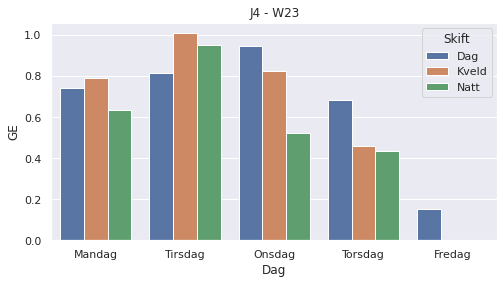

In [48]:
#Plot GE graph
sns.barplot(x='Dag', y='GE', hue='Skift', data=df7_wk, ci=False)
plt.title('J4 - W23')
plt.show()

In [42]:
#Exporting to excel in local disk
from google.colab import files
df7_wk.to_excel('2021_w23_j4_ge.xlsx', index=False) #==> Excluding index from file
files.download('2021_w23_j4_ge.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
#Create function to assign "g/r" categories
def green_red(df):
  df = df.assign(Cat = np.where((df['Material'].str.contains('FREIA 74G')) |
                                (df['Material'].str.contains('SMIL 78G')) |
                                (df['Material'].str.contains('KROKANRULL')), 'Green', 'Red'))
  return df

In [43]:
#Parse categories from product
df7_gr = green_red(df7_week)

In [49]:
#Exporting to excel in local disk
from google.colab import files
df7_gr.to_excel('2021_w23_j4_green_red.xlsx', index=False) #==> Excluding index from file
files.download('2021_w23_j4_green_red.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Monthly Loss Analysis

## Uploading necessary packages

In [ ]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Remove previous versions of excel file
!rm 2021_j4_stops_tracker.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded6 = files.upload()

Saving 2021_j4_stops_tracker.xlsx to 2021_j4_stops_tracker (1).xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df6 = pd.read_excel(io.BytesIO(uploaded6['2021_j4_stops_tracker.xlsx']), index_col='Date')

In [ ]:
#Checking the dataframe info
df6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 513 entries, 2021-01-04 to 2021-06-14
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        513 non-null    int64  
 1   Shift        513 non-null    object 
 2   Group        513 non-null    object 
 3   Product      513 non-null    object 
 4   Format       513 non-null    object 
 5   Start        513 non-null    object 
 6   Last seen    513 non-null    object 
 7   Machine      513 non-null    object 
 8   Work Point   513 non-null    object 
 9   Min          513 non-null    float64
 10  Observation  497 non-null    object 
 11  Solution     57 non-null     object 
dtypes: float64(1), int64(1), object(10)
memory usage: 52.1+ KB


## EDA monthly losses

In [ ]:
#Slicing the dataframe to match the last month
s = '2021-05-01'
f = '2021-05-31'
month = df6[s : f].copy()
month.index[0], month.index[-1]

(Timestamp('2021-05-03 00:00:00'), Timestamp('2021-05-27 00:00:00'))

In [ ]:
#Reinserting the index back to columns and assigning the corresponding month
month = month.reset_index()
month = month.assign(Month = lambda x: x['Date'].dt.strftime('%B'))
month.head()

,Date,Month,Shift,Group,Product,Format,Start,Last seen,Machine,Work Point,Min,Observation,Solution
0,2021-05-03,May,Morning,Fylte,Smil,singel,11:00:00,15:00:00,Choco_process_area,5_Tempering_1,240.0,Temperging machine 1 warming problems,NaN
1,2021-05-03,May,Morning,Fylte,Smil,singel,15:00:00,15:05:00,Moulding_line,32_Mold_crash,5.0,Crash: 2.17A,NaN
2,2021-05-03,May,Afternoon,Fylte,Smil,singel,15:25:00,15:35:00,Moulding_line,32_Mold_crash,10.0,Crash: 2.3A,NaN
3,2021-05-03,May,Afternoon,Fylte,Smil,singel,19:00:00,20:20:00,Moulding_line,32_Mold_crash,80.0,Crash: 1.3A,NaN
4,2021-05-03,May,Afternoon,Fylte,Smil,singel,16:00:00,18:00:00,Packaging_machine_1,17_1_Minor_stoppages,57.0,Packaging machine is not 100%,NaN


In [ ]:
#Groupying by machine and workpoint and computing percentage column
group = month.groupby(['Month', 'Machine', 'Work Point']).agg({'Min':'sum'}).reset_index()
group = group.assign(Perc = lambda x: round((x['Min']/x['Min'].sum())*100, 2))
group.head()

,Month,Machine,Work Point,Min,Perc
0,May,Choco_process_area,5_Tempering_1,720.0,18.10
1,May,Choco_process_area,7_Ingredients_platform,80.0,2.01
2,May,Moulding_line,17_Depositing_2_caramel,51.0,1.28
3,May,Moulding_line,27_Knocking_1,110.0,2.76
4,May,Moulding_line,32_Mold_crash,200.0,5.03


In [ ]:
#Get the sum of all the losses
print(f"Minutes lost: {group.Min.sum()}")

Minutes lost: 3978.4515186081135


In [ ]:
#Exporting to excel into local disk
from google.colab import files
group.to_excel('2021_05_j4_losses.xlsx', index=False) #==>  Exclude index on created file.
files.download('2021_05_j4_losses.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>